# Final Task: Credit Risk Predicition Model
# Project Based Internship ID/X Partners x Rakamin Academy

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb
from scipy.stats import chi2_contingency, f_oneway 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
import copy
warnings.filterwarnings("ignore")

## 2. Load Data & Data Understanding

### Load and Split

In [42]:
# load the dataset
df = pd.read_csv("../Data/loan_data_2007_2014.csv", low_memory=False)

# split data by categorical and numeric
categoric = df.select_dtypes("object")
numeric = df.select_dtypes("number")

# split data by rows and columns
rows = df.shape[0]
cols = df.shape[1]

In [3]:
# display data shape
print("Data shape:")
print(f"Number of rows: {rows} \nNumber of columns: {cols}")

Data shape:
Number of rows: 466285 
Number of columns: 75


### Data Overview

In [4]:
# display data overview
print("Data overview:")
display(df.sample(3))

Data overview:


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
327373,327373,24055300,26427977,16000,16000,16000.0,60 months,16.99,397.56,D,...,NaN,NaN,NaN,NaN,NaN,NaN,54600.0,NaN,NaN,NaN
324541,324541,22471893,24794795,21000,21000,21000.0,60 months,13.98,488.42,C,...,NaN,NaN,NaN,NaN,NaN,NaN,65100.0,NaN,NaN,NaN
62675,62675,8945098,10737210,20000,20000,20000.0,60 months,18.55,513.88,D,...,NaN,NaN,NaN,NaN,NaN,NaN,25900.0,NaN,NaN,NaN


In [5]:
# display categorical data summary
print("Categorical data summary:")
display(categoric.describe())

Categorical data summary:


,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
count,466285,466285,466285,438697,445277,466285,466285,466285,466285,466285,...,466285,466264,466285,466285,466256,466285,465909,239071,466243,466285
unique,2,7,35,205475,11,6,3,91,9,2,...,14,63098,888,50,664,2,98,100,103,1
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-14,Current,n,...,debt_consolidation,Debt consolidation,945xx,CA,Oct-00,f,Jan-16,Feb-16,Jan-16,INDIVIDUAL
freq,337953,136929,31686,5399,150049,235875,168055,38782,224226,466276,...,274195,164075,5304,71450,3674,303005,179620,208393,327699,466285


In [6]:
# display numerical data summary
print("Numerical data summary:")
display(numeric.describe())

Numerical data summary:


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,466285.000000,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,233142.000000,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,...,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,134605.029472,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,...,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,0.000000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,116571.000000,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,233142.000000,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,...,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,349713.000000,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,...,NaN,NaN,NaN,NaN,NaN,NaN,3.790000e+04,NaN,NaN,NaN
max,466284.000000,3.809811e+07,4.086083e+07,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,...,NaN,NaN,NaN,NaN,NaN,NaN,9.999999e+06,NaN,NaN,NaN


### Types of Data

In [7]:
# checking for types of data
with pd.option_context("display.max_rows", None):
    print(df.dtypes)

Unnamed: 0                       int64
id                               int64
member_id                        int64
loan_amnt                        int64
funded_amnt                      int64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                      

### Data Review

In [8]:
# Review all categorical data values
for col in categoric.columns:
    print(categoric[col].value_counts())
    print("-"*35,"*"*3)

term
36 months    337953
60 months    128332
Name: count, dtype: int64
----------------------------------- ***
grade
B    136929
C    125293
D     76888
A     74867
E     35757
F     13229
G      3322
Name: count, dtype: int64
----------------------------------- ***
sub_grade
B3    31686
B4    30505
C1    26953
C2    26740
B2    26610
C3    25317
B5    25252
C4    24105
B1    22876
C5    22178
A5    21757
D1    19261
A4    19045
D2    17046
D3    14916
D4    14099
A3    12568
D5    11566
A2    10956
A1    10541
E1     9033
E2     8669
E3     6976
E4     5992
E5     5087
F1     3940
F2     3001
F3     2708
F4     2067
F5     1513
G1     1109
G2      823
G3      583
G4      422
G5      385
Name: count, dtype: int64
----------------------------------- ***
emp_title
Teacher                              5399
Manager                              4438
Registered Nurse                     2316
RN                                   2204
Supervisor                           1967
                 

In [9]:
# Review all numerical data values
for col in numeric.columns:
    print(numeric[col].value_counts())
    print("-"*35,"*"*3)

Unnamed: 0
0         1
310839    1
310865    1
310864    1
310863    1
         ..
155424    1
155423    1
155422    1
155421    1
466284    1
Name: count, Length: 466285, dtype: int64
----------------------------------- ***
id
1077501     1
26180404    1
26219322    1
26239577    1
26290537    1
           ..
3714715     1
3703738     1
3731030     1
3705772     1
9199665     1
Name: count, Length: 466285, dtype: int64
----------------------------------- ***
member_id
1296599     1
28653081    1
28692177    1
28702376    1
28763241    1
           ..
4686866     1
4847180     1
4724047     1
4678105     1
11061576    1
Name: count, Length: 466285, dtype: int64
----------------------------------- ***
loan_amnt
10000    33023
12000    25519
15000    23486
20000    22759
35000    16596
         ...  
34250        1
33400        1
32150        1
34325        1
33175        1
Name: count, Length: 1352, dtype: int64
----------------------------------- ***
funded_amnt
10000    32930
12000   

### Columns Issue

Based on the data review, there are several columns that have problems:
#### `1. Imbalanced columns`
Here are the columns with Imbalanced data:
- pymnt_plan

#### `2. High cardinality columns`
Here are the columns that have too many unique values:
- emp_title
- title
- zip_code
- url
- desc

#### `3. Low cardinality columns`
Here are the column that has too few unique values:
- application_type
- policy_code
- acc_now_delinq

Here are the columns that are possible to generalize:
- addr_state

#### `4. Unnecessary columns`
Here are the column that will not be included in the model:
- Unnamed: 0
- id
- member_id
- collections_12_mths_ex_med

## 3. Exploratory Data Analysis (EDA)

### Value Checking

#### 1. Missing values checking

In [10]:
# define a missing values checking function
def check_missing(data, op, pct):
    # sort for missing values columns percentage
    sorted_missing_pct = sorted(data, key=lambda x: (data[x].isnull().sum() / len(data)), reverse=True)
    
    # variable to count the number of missing values
    cnt_missing_cols = 0
    cnt_missing_cols_pct = 0

    # define columns that have missing values
    data_name = [name for name, value in globals().items() if value is data][0]
    print(f"{data_name} columns with missing values:")

    # iterate columns with missing values
    for col in sorted_missing_pct:
        missing_pct = (data[col].isnull().sum() / len(data)) * 100

        if op == ">" and missing_pct > 0:
            num_missing_pct = missing_pct > pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

        elif op == "<" and missing_pct > 0:
            num_missing_pct = missing_pct < pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

        elif op == "=" and missing_pct > 0:
            num_missing_pct = missing_pct == pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

        elif op == "!=" and missing_pct > 0:
            num_missing_pct = missing_pct != pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

    print(f"\nTotal columns with missing values is {cnt_missing_cols} columns")
    print(f"Total columns with {op}{pct}% missing values is {cnt_missing_cols_pct} columns")

In [11]:
# run the function
check_missing(df, ">", 40)
print("-"*55)
check_missing(categoric, ">", 40)
print("-"*55)
check_missing(numeric, ">", 40)

df columns with missing values:
annual_inc_joint (100.00%)
dti_joint (100.00%)
verification_status_joint (100.00%)
open_acc_6m (100.00%)
open_il_6m (100.00%)
open_il_12m (100.00%)
open_il_24m (100.00%)
mths_since_rcnt_il (100.00%)
total_bal_il (100.00%)
il_util (100.00%)
open_rv_12m (100.00%)
open_rv_24m (100.00%)
max_bal_bc (100.00%)
all_util (100.00%)
inq_fi (100.00%)
total_cu_tl (100.00%)
inq_last_12m (100.00%)
mths_since_last_record (86.57%)
mths_since_last_major_derog (78.77%)
desc (72.98%)
mths_since_last_delinq (53.69%)
next_pymnt_d (48.73%)
tot_coll_amt (15.07%)
tot_cur_bal (15.07%)
total_rev_hi_lim (15.07%)
emp_title (5.92%)
emp_length (4.51%)
last_pymnt_d (0.08%)
revol_util (0.07%)
collections_12_mths_ex_med (0.03%)
last_credit_pull_d (0.01%)
delinq_2yrs (0.01%)
earliest_cr_line (0.01%)
inq_last_6mths (0.01%)
open_acc (0.01%)
pub_rec (0.01%)
total_acc (0.01%)
acc_now_delinq (0.01%)
title (0.00%)
annual_inc (0.00%)

Total columns with missing values is 40 columns
Total columns

Number of missing value:
- There are many missing values in the dataframe column. 40 columns contain missing values and 22 columns contain more than 40% missing values.
- In the categorical column. 8 columns contain missing values and 2 columns contain more than 40% missing values.
- In the numerical column. 32 columns contain missing values and 20 columns contain more than 40% missing values.

Action:
- For columns with missing values more than 40%, I will drop them later
- For the rest of the columns that still contain missing values I decided to impute them later

#### 2. Duplicate values checking

In [12]:
# define a duplicate values checking function
def check_duplicate(data):
    cnt_duplicate = data.duplicated().sum()
    data_name = [name for name, value in globals().items() if value is data][0]
    print(f"Total duplicate values in {data_name} columns: \n{cnt_duplicate}")

# run the function
check_duplicate(df)

Total duplicate values in df columns: 
0


This dataset doesn"t contain any duplicate values.

#### 3. Outlier checking

##### 3.1. Column selection with no missing values

In [13]:
# create a copy of dataframe
numeric_copy = numeric.copy()

# define a missing percentage function to list a columns with missing values
def missing_pct(data, pct):
    miss_cols = []

    for col in data:
        missing_val = (data[col].isnull().sum() / len(data)) * 100
        if missing_val > pct:
            miss_cols.append(col)
    return miss_cols

# create a variable: numeric columns without missing values
numeric_without_miss = numeric_copy.drop(columns=missing_pct(numeric, 40))

# print columns with missing values more than 40%
print(numeric_without_miss.columns)

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')


##### 3.2. With Boxplot

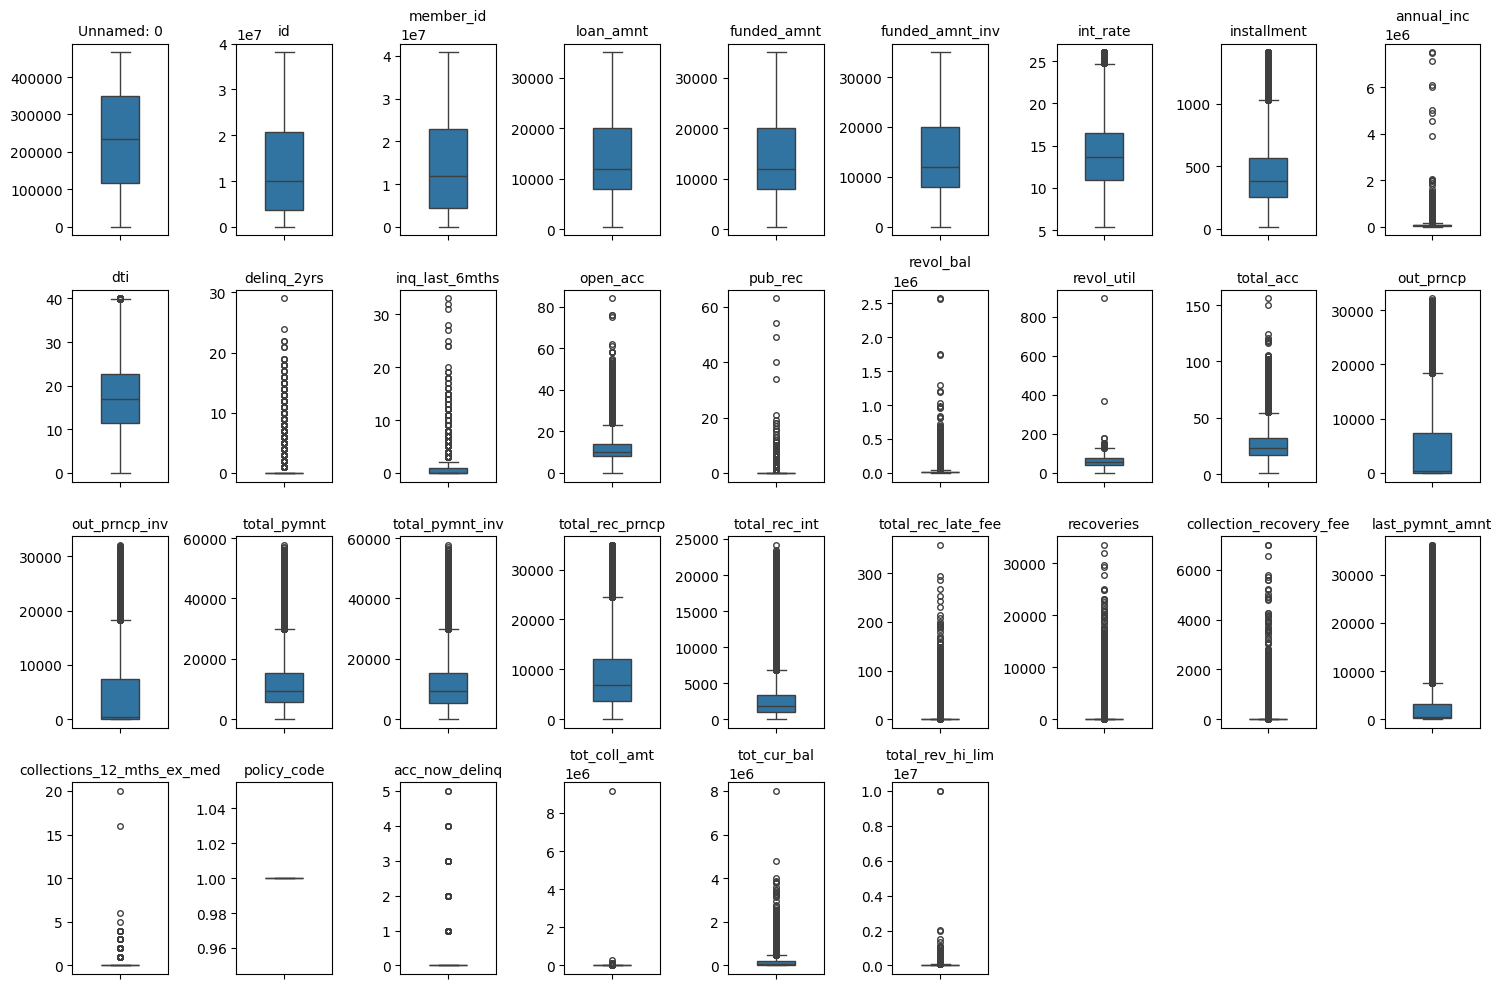

In [14]:
# loop boxplot for each columns in numeric_without_miss dataframe
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_without_miss.columns):
    plt.subplot(4, 9, i+1)
    sns.boxplot(numeric[col], width=0.4, fliersize=4)
    plt.ylabel(None)
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.show()

##### 3.3. With KDE plot

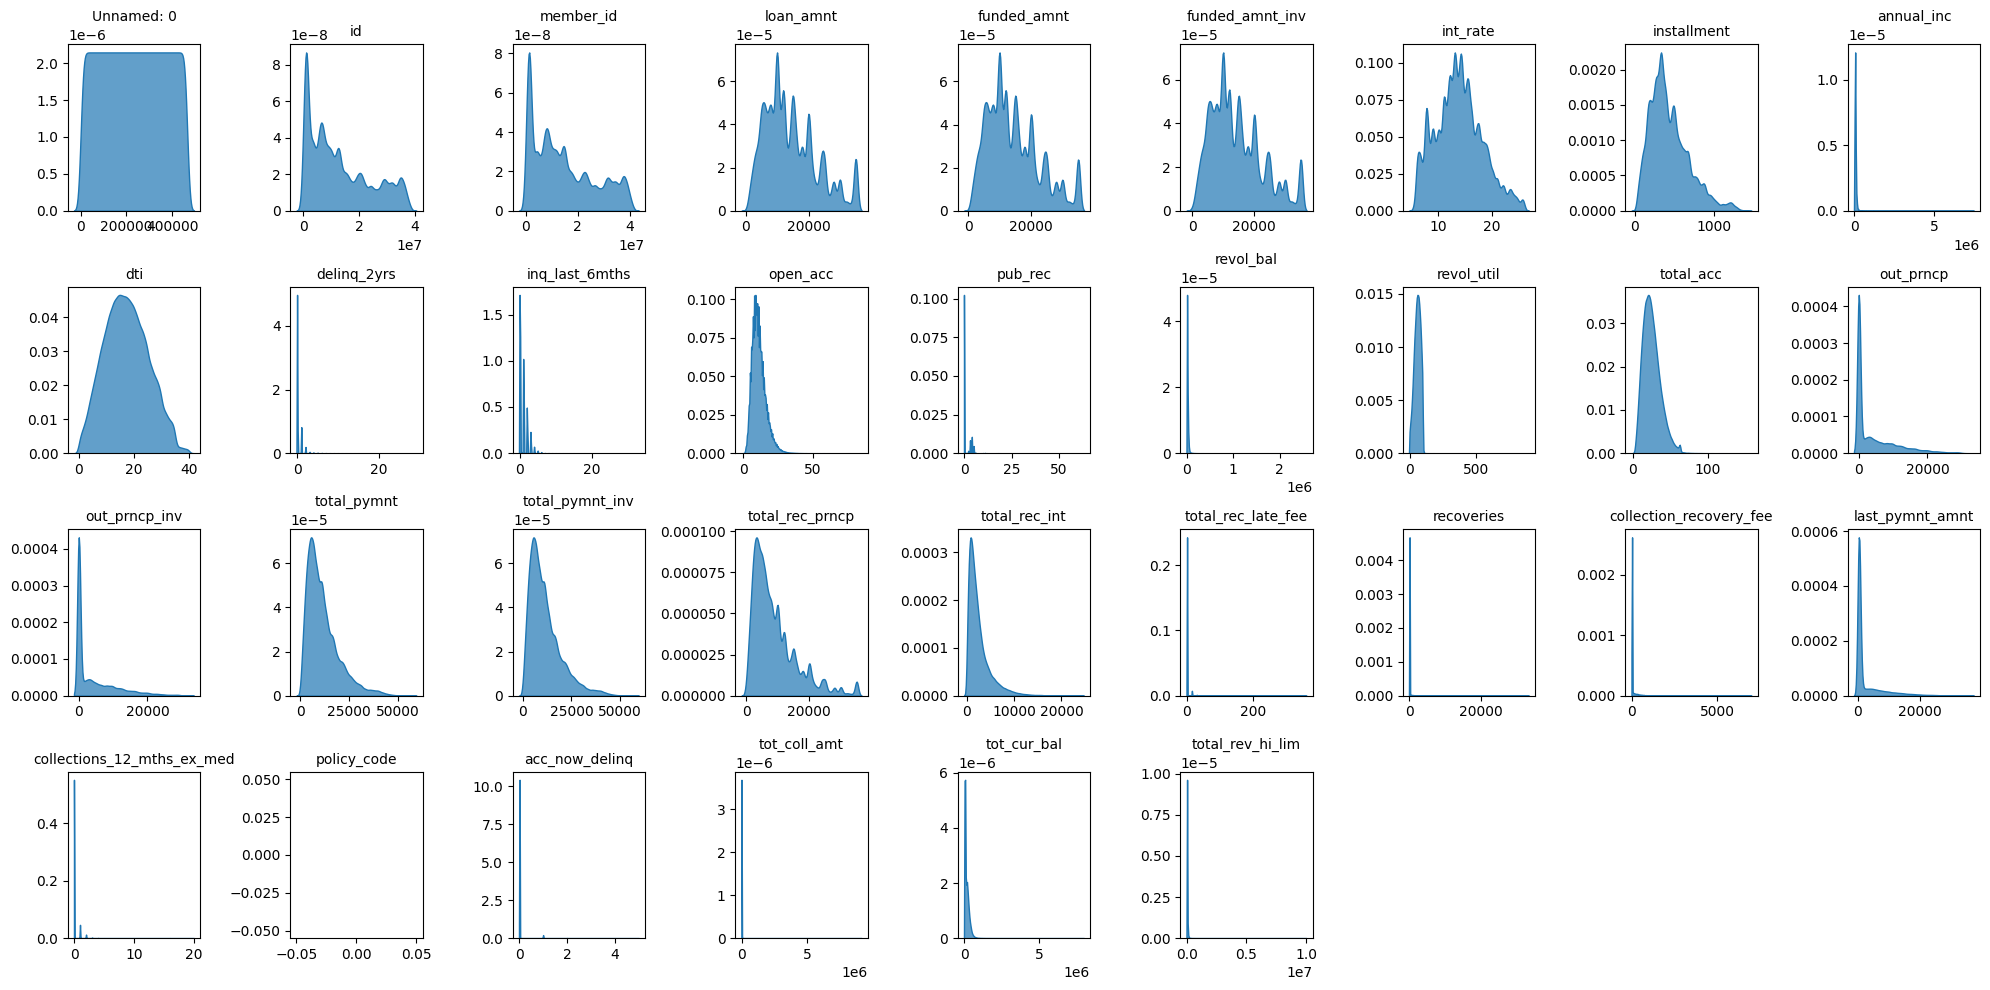

In [15]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(numeric_without_miss.columns):
    plt.subplot(4, 9, i+1)
    sns.kdeplot(numeric[col], fill=True, alpha=0.7)
    plt.title(col, fontsize=10)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.tight_layout()

# Display the plot 
plt.show()

- Most of these numerical data distributions are positively skewed
- Columns with more than 40% missing values will be dropped
- Columns that have less than 40% missing values will be filled with median

##### 3.4. With Z-Score

In [16]:
# define a z-score function
def check_outliers_zscore(data, cols_name=None):
    outliers = []
    cols_name = data.columns

    for i, col in enumerate(data.columns):
        mean = np.mean(data[col])
        std = np.std(data[col])

        threshold = 3
        
        z_scores = [(x - mean)/std for x in data[col]]
        col_outliers = [i for i, z in enumerate(z_scores) if abs(z) > threshold]

        if len(col_outliers) > 0:
            outliers.append(cols_name[i])

    return outliers

In [17]:
# run check_outliers_zscore function
print(f"Total columns with outliers: {len(check_outliers_zscore(numeric_without_miss))} columns")
check_outliers_zscore(numeric_without_miss)

Total columns with outliers: 24 columns


['installment',
 'annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim']

### Target Variable

Based on the purpose of creating this model, namely to predict credit risk, I will divide the loan_status column into two groups (good or bad loans). Where:
- Bad: Default, Charged Off, Late (31-120 days), Late (16-30 days), Does not meet the credit policy. Status:Charged Off, In Grace Period

- Good: Fully Paid, Current, Does not meet the credit policy. Status: Fully Paid

In [18]:
#Target variable: loan_status column
loan_status_copy = copy.deepcopy(df["loan_status"])

loan_status_copy.value_counts()

loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

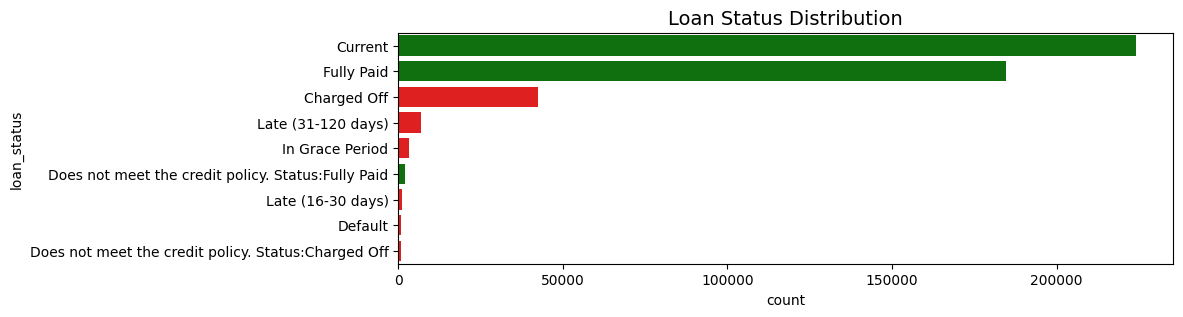

In [19]:
# visualize loan_status column distribution
order_loan = df["loan_status"].value_counts().sort_values(ascending=False).index

colors_gr = ["green" if status in ["Current", "Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]
                            else "red" for status in order_loan]

plt.figure(figsize=(10, 3))

# Loan Status Distribution
sns.countplot(data=df, y="loan_status", order=order_loan, palette=colors_gr)
plt.title("Loan Status Distribution", fontsize=14)

plt.show()

In [49]:
# separate between good loans and bad loans
def good_bad_loan(status):
    return "Good Loan" if status in ["Current", "Fully Paid", "Does not meet the credit policy. Status:Fully Paid"] else "Bad Loan"

# apply the map good_bad_loan to loan_status column
df["loan_status"] = df["loan_status"].apply(good_bad_loan)

Loan status distribution:
loan_status
Good Loan    410953
Bad Loan      55332
Name: count, dtype: int64

Loan status distribution percentage:
Good Loan: 88.13%
Bad Loan: 11.87%

Assumed Total loss and profit:
Total profit: 5873258514.61
Total loss: 790793935.39


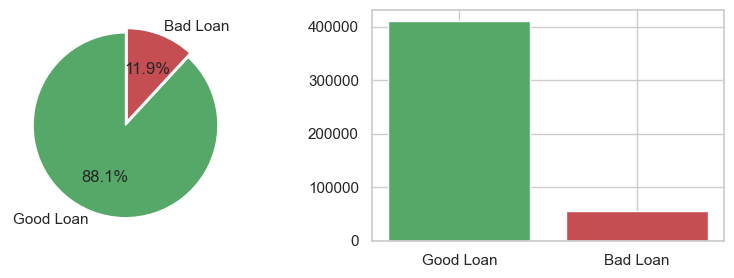

In [50]:
# create a a value counts of good loan and bad loan
cnt_good = df["loan_status"].value_counts()[0]
cnt_bad = df["loan_status"].value_counts()[1]

# create a good and bad loan percentage
total_loan = cnt_good + cnt_bad
loan_good_pct = (cnt_good / total_loan)*100
loan_bad_pct = (cnt_bad / total_loan)*100

# assume total loans to good loans as profit and otherwise
avg_loan_amount = df["funded_amnt"].mean()
total_profit = cnt_good*avg_loan_amount
total_loss = cnt_bad*avg_loan_amount

# print the result
print(f"Loan status distribution:\n{df["loan_status"].value_counts()}\n")
print(f"Loan status distribution percentage:\nGood Loan: {loan_good_pct:.2f}%\nBad Loan: {loan_bad_pct:.2f}%\n")
print(f"Assumed Total loss and profit:\nTotal profit: {total_profit:.2f}\nTotal loss: {total_loss:.2f}")

# create a value counts of loan_status and its index
loan_val = df["loan_status"].value_counts()
loan_val_label = loan_val.index

# create a pie chart
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.pie(loan_val, labels=loan_val_label,
        autopct="%1.1f%%", 
        startangle=90, colors=["g", "r"],
        explode=[0., 0.05])

# create a bar plot
plt.subplot(1, 2, 2)
plt.bar(loan_val_label, loan_val, color=["g", "r"])

plt.show()

- Based on the value distribution of the loan_status column, there is an imbalance between the value of Good Loan of **88.13%** and Bad Loan of **11.87%**.

- The total loans included in the Good Loan category are **$5,873,258,514** while for Bad Loan is **$79,0793,935**.


### Plotting Function

#### 1. Define Line Plot

In [297]:
def add_lineplot(data, x, y, palette=None, hue=None, ci=95):
    sns.lineplot(data=data, x=x, y=y, palette=palette, hue=hue, ci=ci)

    # add some informations
    plt.title(f"{hue.replace("_", " ").title()} {y.replace("_", " ").title()} by {x.replace("_", " ").title()}", fontsize="large")
    plt.xlabel(f"{x.replace("_", " ").title()}")
    plt.ylabel(f"{y.replace("_", " ").title()}")
    plt.legend(title=hue.replace("_", " ").title(), fontsize="small", bbox_to_anchor=(1.02, 1), loc="upper left")

#### 2. Define Bar Plot

In [67]:
def add_barplot(data, x, y, palette=None, hue=None, order=None):
    sns.barplot(data=data, x=x, y=y, palette=palette, hue=hue, order=order)
    
    # add some informations
    plt.title(f'{y.replace("_", " ").title()} by {x.replace("_", " ").title()}', fontsize="large")
    plt.xlabel(f'{x.replace("_", " ").title()}')
    plt.ylabel(f'{y.replace("_", " ").title()}')

#### 3. Define Stacked Bar Plot

In [251]:
def add_st_barplot(data, x, y, palette=None, order=None):
    # calculate the value of loan status by region
    status_dis = data.groupby(x)[y].value_counts().unstack()
    status_dis = status_dis.reindex(order)

    # convert to percentage
    total_dis = status_dis.sum(axis=1)
    total_dis_pct = status_dis.apply(lambda i: i / total_dis * 100, axis=0)

    # Create the Good Loan and Bad Loan input
    bar1 = plt.bar(total_dis_pct.index,
                    total_dis_pct["Good Loan"],
                    label="Good Loan",
                    color=palette[0])
    bar2 = plt.bar(total_dis_pct.index,
                    total_dis_pct["Bad Loan"],
                    label="Bad Loan",
                    color=palette[1],
                    bottom=total_dis_pct["Good Loan"])

    # Add percentage annotations
    for bar1, bar2 in zip(bar1, bar2):
        percentage1 = bar1.get_height()
        percentage2 = bar2.get_height()

        plt.text(bar1.get_x() + bar1.get_width() / 2,
                 percentage1 / 2,
                 f"{percentage1:.2f}%",
                 color="w",
                 ha='center',
                 va='center',)

        plt.text(bar2.get_x() + bar2.get_width() / 2,
                 percentage1 + percentage2 / 2,
                 f"{percentage2:.2f}%",
                 color="w",
                 ha='center',
                 va='center',)

    # add some informations
    plt.title(f"Default Rate by {x.replace("_", " ").title()}",  fontsize="large")
    plt.xlabel(f"{x.replace("_", " ").title()}")
    plt.ylabel("Total Clients (%)")
    plt.legend(title=y.replace("_", " ").title(),  fontsize="small",  bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(None)

#### 4. Define Pie Plot

In [237]:
def add_pieplot(data, label, palette=None, threshold=1):
    label_counts = data[label].value_counts()
    
    _, _, text = plt.pie(label_counts,
                         labels=label_counts.index,
                         colors=palette,
                         autopct=lambda p: f'{p:.2f}%' if p >= threshold else '',
                         startangle=90)

    # Set the color percentage to white
    for t in text:
        t.set_color('white')

    # add some informations
    plt.title(f'Distribution of {label.replace("_", " ").title()}', fontsize="large")
    plt.axis('equal')

### Analysis

#### 1. Analysis by Loan Year

##### Create Years Column

In [262]:
# change issue_d column to date format (month and year)
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%y")

# create years columns from issue_d
df["years"] = df["issue_d"].dt.year

##### Visualize

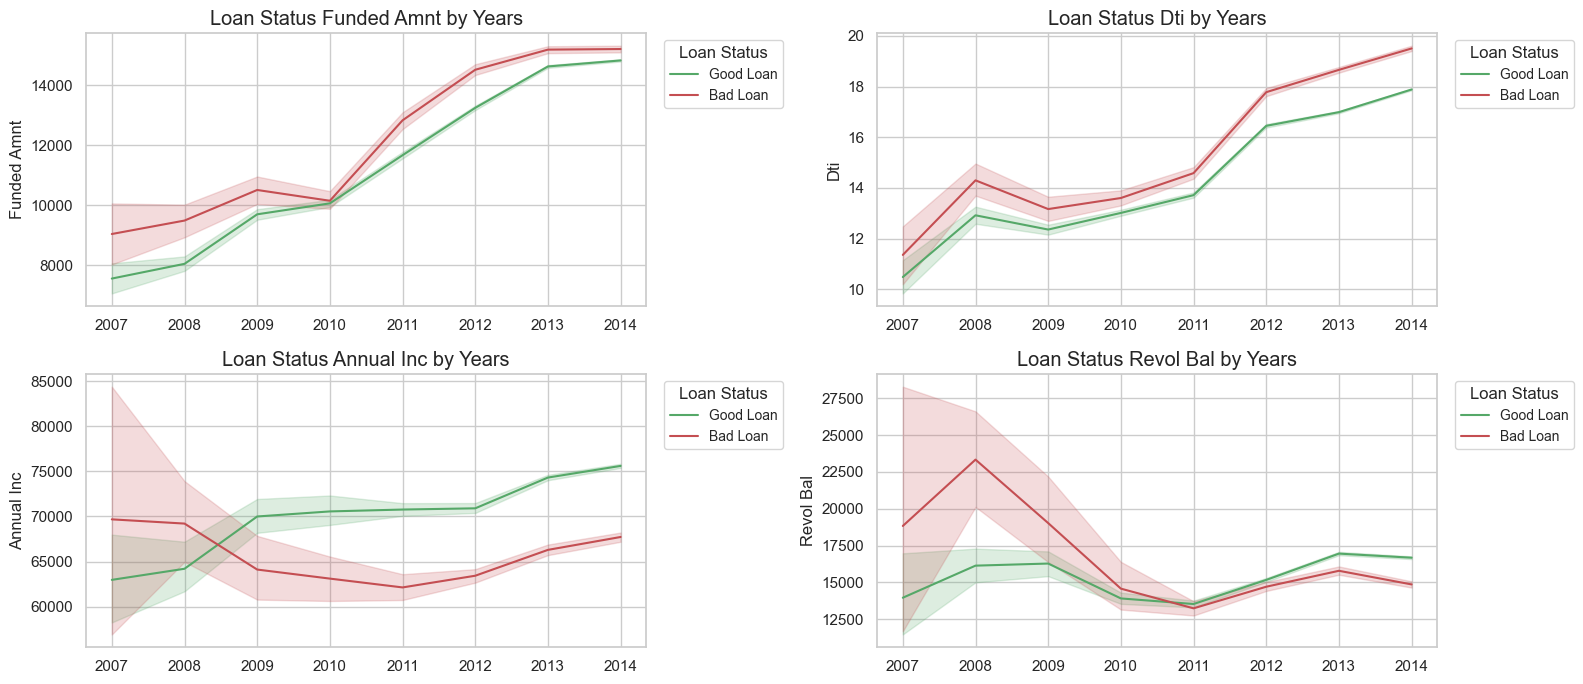

In [298]:
# visualize loan year analysis
plt.figure(figsize=(16, 7))

# Funded amount by loan status (in years)
plt.subplot(2, 2, 1)
add_lineplot(data=df, x="years", y="funded_amnt", palette=["g", "r"], hue="loan_status")
plt.xlabel(None)

# DTI by loan status (in years)
plt.subplot(2, 2, 2)
add_lineplot(data=df, x="years", y="dti", palette=["g", "r"], hue="loan_status")
plt.xlabel(None)

# Annual Income by loan status (in years)
plt.subplot(2, 2, 3)
add_lineplot(data=df, x="years", y="annual_inc", palette=["g", "r"], hue="loan_status")
plt.xlabel(None)

# Revolving balance by loan status (in years)
plt.subplot(2, 2, 4)
add_lineplot(data=df, x="years", y="revol_bal", palette=["g", "r"], hue="loan_status")
plt.xlabel(None)

plt.tight_layout()
plt.show()

##### Insight

- Funded amount by loan status (in years)
    - The number of loans given has increased every year
    - Overall, the number of loans with Good Loan status is smaller than Bad Loan status
    - Around 2009 there was a small decrease in Bad Loan until the following year. And starting in 2010 Bad Loan experienced a significant increase
    - In 2013 and subsequent years, Good Loan and Bad Loan approached the same value, and stagnated at the same time
    - This data indicates that the number of loans is increasing over time

- DTI by loan status (in years)
    - DTI (Debt to Income) continues to increase over time
    - There was a simultaneous decrease of Good Loan and Bad Loan in 2008, but it increased again for the following years
    - Interestingly, there is a similar pattern between Good Loan and Bad Loan when experiencing a decrease and increase

- Annual Income by loan status (in years)
    - There is a unique phenomenon here, the annual income from Good Loan is initially lower than Bad Loan, but over time it has increased quite consistently
    - The opposite happened with Bad Loan, there was a big decline over time, and started to see a slight increase starting in 2011
    - Annual income from Good Loan and Bad Loan were at the same value in mid-2008

- Revolving balance by loan status (in years)
    - In 2008 there was a significant decrease in revolving balance, this seems to be related to annual income and debt to income which decreased at the same time.
    - This could indicate that they are trying to reduce their financial burden and improve their financial stability, or it could be a sign that borrowers want to reduce reliance on revolving credit.

#### 2. Analysis by Region

##### Create Regions Column

In [92]:
print(f"Region list:\n{df["addr_state"].unique()}")
print(f"\nI will group the names of regions based on their abbreviations. These regions will be divided by region within the US state.")

Region list:
['AZ' 'GA' 'IL' 'CA' 'OR' 'NC' 'TX' 'VA' 'MO' 'CT' 'UT' 'FL' 'NY' 'PA'
 'MN' 'NJ' 'KY' 'OH' 'SC' 'RI' 'LA' 'MA' 'WA' 'WI' 'AL' 'CO' 'KS' 'NV'
 'AK' 'MD' 'WV' 'VT' 'MI' 'DC' 'SD' 'NH' 'AR' 'NM' 'MT' 'HI' 'WY' 'OK'
 'DE' 'MS' 'TN' 'IA' 'NE' 'ID' 'IN' 'ME']

I will group the names of regions based on their abbreviations. These regions will be divided by region within the US state.


In [ ]:
West = ["CA", "NV", "UT", "CO", "WY", "MT", "ID", "OR", "WA", "AK", "HI"]

Southwest = ["AZ", "NM", "TX", "OK"]

Midwest = ["ND", "MN", "SD", "NE", "KS", "MO", "IA", "WI", "IL", "IN", "OH", "MI"]
 
Southeast = ["AR", "LA", "MS", "AL", "GA", "TN", "KY", "NC", "SC", "WV", "DC", "VA", "DE", "FL"]

Northeast = ["PA", "MD", "NJ", "NY", "CT", "RI", "MA", "NH", "VT", "ME"]

In [96]:
def us_region(state):
    if state in West:
        return "West"

    elif state in Southwest:
        return "Southwest"

    elif state in Midwest:
        return "Midwest"

    elif state in Southeast:
        return "Southeast"

    elif state in Northeast:
        return "Northeast"

    else:
        return "Other"

# Apply the function us_region to "addr_state" column
df["region"] = df["addr_state"].apply(us_region)

##### Visualize

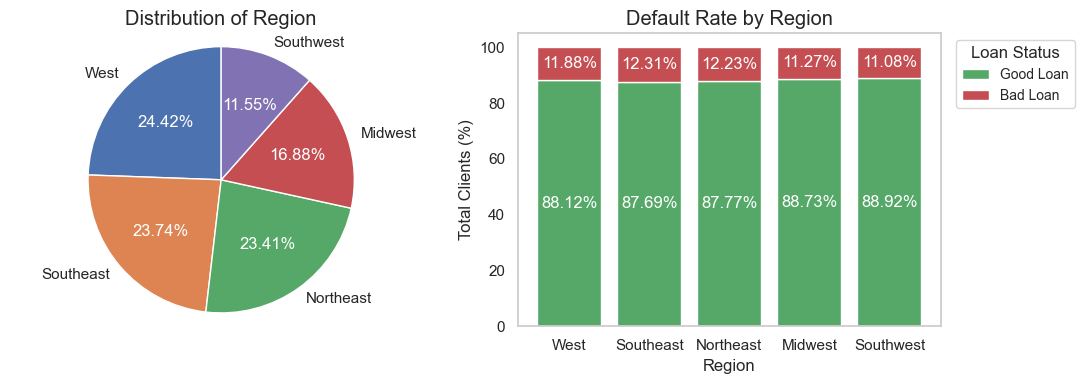

In [238]:
region_order = df["region"].value_counts().index

# visualize regions column analysis
plt.figure(figsize=(11, 4))

# pie plot distribution of region
plt.subplot(1, 2, 1)
add_pieplot(df, "region")

# stacked barplot default rate by region
plt.subplot(1, 2, 2)
add_st_barplot(df, 'region', 'loan_status', order=region_order, palette=["g", "r"])

plt.tight_layout()
plt.show()

##### Insight

- Distribution of Region
    - The largest number of loans are in the west, southeast, and northeast regions
    - While the smallest number of loans is in the southwest region with a difference of twice that of the west region

- Default Rate by Region
    - There is no significant difference in default rates between regions
    - The region with the largest default rate is the southeast region, while the smallest is in the southwest region

#### 3. Analysis by State

##### Visualize

addr_state
CA    71450
NY    40242
TX    36439
FL    31637
IL    18612
Name: count, dtype: int64


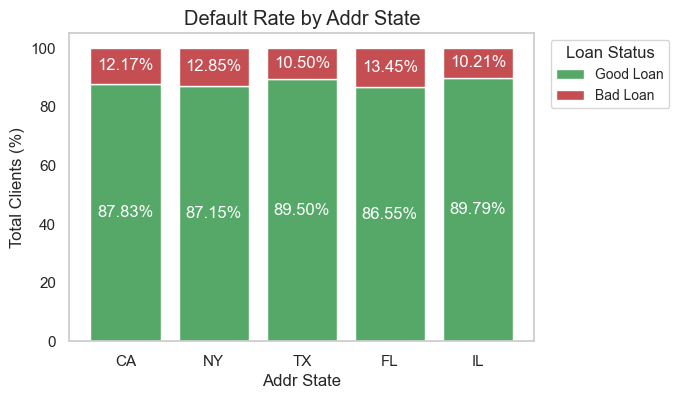

In [197]:
# select the top 5 state
top_states = df.addr_state.value_counts().head(5).index

# get the number of each state
print(df.addr_state.value_counts().head(5))

# visualize analysis by state
plt.figure(figsize=(6, 4))

add_st_barplot(df, 'addr_state', 'loan_status', order=top_states, palette=["g", "r"])

plt.show()

##### Insight

- Top Clients with a loan value of **71,450** are from the state of CA (California) with a default rate of 12.17%
- Clients with a highest good loan value are from the state of IL (Illinois) with **89.79%**
- Clients with the highest default rate is the state of Fl (Florida) with **13.45%**

#### 4. Analysis of Loan Purpose

##### Visualize

purpose
debt_consolidation    274195
credit_card           104157
home_improvement       26537
other                  23690
major_purchase          9828
Name: count, dtype: int64


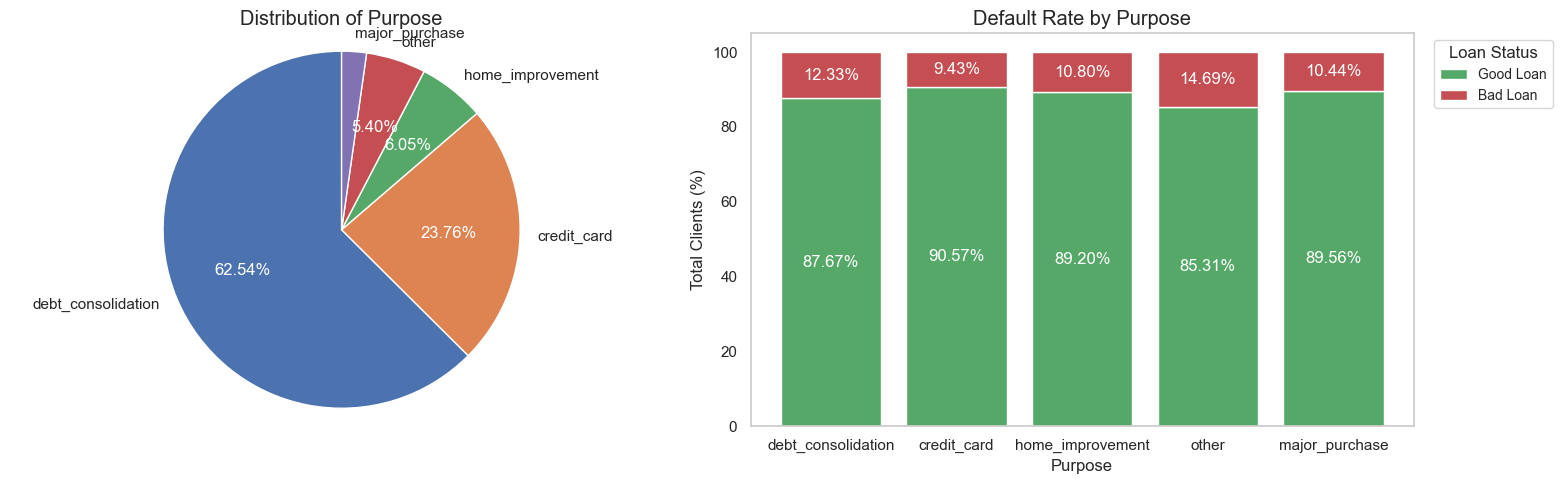

In [252]:
# get the number of top purpose
print(df["purpose"].value_counts().head(5))

# get top 5 purpose
top_pvalue = df["purpose"].value_counts().head(5).index
top_purpose = df[df["purpose"].isin(top_pvalue)]
purpose_order = top_purpose["purpose"].value_counts().index

# Visualize loan purpose analysis
plt.figure(figsize=(16, 5))

# pie plot distribution of purpose
plt.subplot(1, 2, 1)
add_pieplot(top_purpose, "purpose", threshold=4)

# stacked barplot default rate by purpose
plt.subplot(1, 2, 2)
add_st_barplot(top_purpose, "purpose", 'loan_status', order=purpose_order, palette=["g", "r"])

plt.tight_layout()
plt.show()

##### Insight

- The top 5 loan purpose are debt consolidation, credit card, home improvement, other, and major purchase
- Debt consolidation dominated most of the total loans with **62.54%**
- Purpose with a highest good loan value is credit_card with **9.43%**
- Purpose with the highest default rate are from other with **14.69%**

#### 5. Analysis of Loan Grade

##### Visualize

Grade list:
['A' 'B' 'C' 'D' 'E' 'F' 'G']


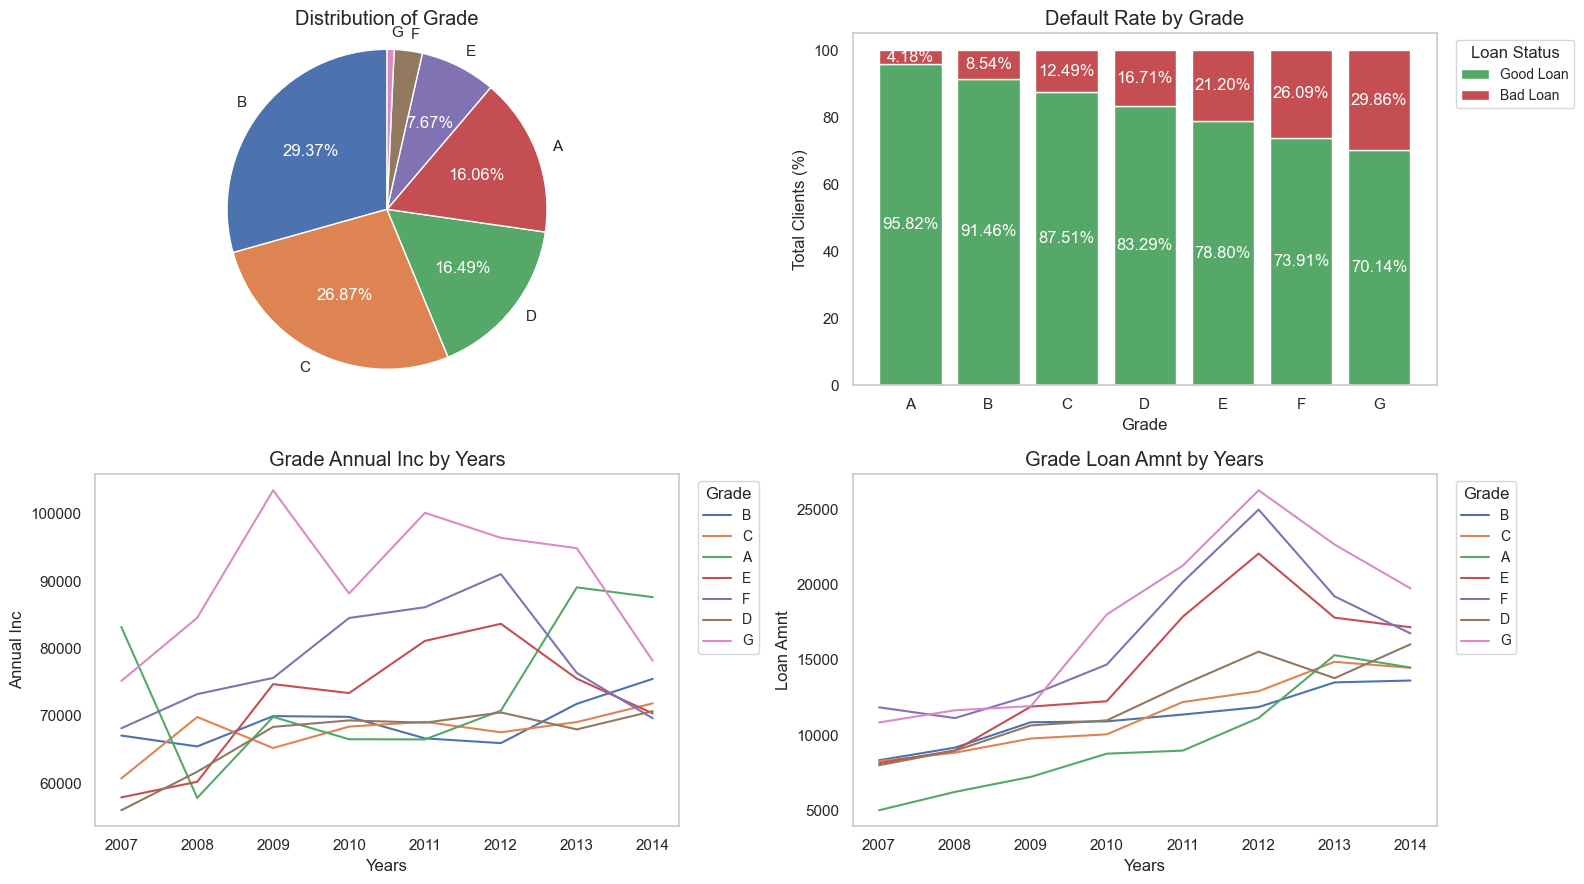

In [306]:
# print value of grade column
print(f"Grade list:\n{df["grade"].sort_values().unique()}")

# visualize loan grade analysis
plt.figure(figsize=(16, 9))

# sort grade values
grade_order = df["grade"].sort_values()

# pie plot distribution of grade
plt.subplot(2, 2, 1)
add_pieplot(df, 'grade', threshold=7)

# Stacked barplot default rate by grade
plt.subplot(2, 2, 2)
add_st_barplot(df, 'grade', 'loan_status', palette=["g", "r"])

# line plot of grade annual income by years
plt.subplot(2, 2, 3)
add_lineplot(data=df, x="years", y="annual_inc", hue="grade", ci=None)
plt.grid(None)

# line plot of grade loan amount by years
plt.subplot(2, 2, 4)
add_lineplot(data=df, x="years", y="loan_amnt", hue="grade", ci=None)
plt.grid(None)

plt.tight_layout()
plt.show()

##### Insight